In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
import datetime

data_dir = os.environ.get('data_dir', 'data')
print("Data dir: {}".format(data_dir))

_date = datetime.datetime.strptime(os.environ.get('DATE', '2019-11-28'), "%Y-%m-%d")
_last_hour = datetime.datetime.strptime(os.environ.get('LASH_HOUR', '18:00:00'), "%H:%M:%S") - datetime.datetime(1900, 1, 1)
_length_hours = datetime.timedelta(hours=int(os.environ.get('LENGTH_HOURS', '4')))

time_range = (_date + _last_hour - _length_hours, _date + _last_hour)
print("Time range: ", time_range)

Data dir: data
Time range:  (datetime.datetime(2019, 11, 28, 14, 0), datetime.datetime(2019, 11, 28, 18, 0))


In [3]:
from yt import yson

with open(os.path.join(data_dir, "pool_trees.yson"), "rb") as f:
    pool_trees = yson.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/pool_trees.yson'

In [4]:
def _update_mapping(name, node, mapping):
    mapping[name] = node
    for pool, child in node.items():
        _update_mapping(pool, child, mapping)

def build_pool_name_mapping(pool_trees, tree_name):
    tree = pool_trees[tree_name]
    result = {}
    _update_mapping("<Root>", tree, result)
    return result

In [7]:
pool_name_mapping = build_pool_name_mapping(pool_trees, "physical")

In [73]:
from copy import deepcopy

def _update_path_mapping(name, node, mapping, list_mapping, prefix=[]):
    prefix.append(name)
    mapping[name] = set(prefix)
    list_mapping[name] = deepcopy(prefix)
    for pool, child in node.items():
        _update_path_mapping(pool, child, mapping, list_mapping, prefix)
    prefix.pop()
        
def build_pool_path_mapping(pool_trees, tree_name):
    tree = pool_trees[tree_name]
    result = {}
    list_result = {}
    _update_path_mapping("<Root>", tree, result, list_result)
    return result, list_result

In [74]:
pool_path_mapping, pool_path_list_mapping = build_pool_path_mapping(pool_trees, "physical")

In [10]:
def is_parent(parent, name):
    return parent in pool_path_mapping[name]

In [11]:
from analyze_simulation import parse_timestamp as parse_timestamp

def read_events():
    def convert(yson_s):
        return yson.loads(yson_s.encode('utf-8'))
    
    return pd.read_csv(os.path.join(data_dir, "preemption_events.csv"), converters={
        "statistics": convert,
        "resource_limits": convert,
    })

def check_unknown(df):
    def pred(row):
        return row['preemptor_pool'] not in pool_name_mapping
    unk_preemptor = df[df.apply(pred, axis=1)]
    return unk_preemptor
    

def preprocess_events(df):
    def unknown_preempted(row):
        return 0 if row['preempted_pool'] in pool_name_mapping else 1
    def unknown_preemptor(row):
        return 0 if row['preemptor_pool'] in pool_name_mapping else 1
    
    unk_preempted = df.apply(unknown_preempted, axis=1).sum()
    unk_preemptor = df.apply(unknown_preemptor, axis=1).sum()
    print(unk_preempted, unk_preemptor)
    
    def fix_pools(row):
        if row['preempted_pool'] not in pool_name_mapping:
            row['preempted_pool'] = 'research'
        if row['preemptor_pool'] not in pool_name_mapping:
            row['preemptor_pool'] = 'research'
        return row
    
    def fix_timestamp(row):
        # Parse and adjust for Moscow time zone
        row['timestamp'] = parse_timestamp(row['timestamp']) + datetime.timedelta(hours=3)
        return row
    
    def fix(row):
        row = fix_pools(row)
        row = fix_timestamp(row)
        return row
    
    df = df.apply(fix, axis=1)
    return df

In [12]:
preemptions = read_events()

In [ ]:
check_unknown(preemptions)

In [13]:
preemptions = preprocess_events(preemptions)

953128 99922


In [14]:
from functools import lru_cache

def _filter_dataframe(df, predicate):
    return df[df.apply(predicate, axis=1)]

def _create_subtree_checker(parent):
    def pred(f, t):
        return (is_parent(parent, f) and is_parent(parent, t))
    return pred

def _create_one_vs_one_checker(parent1, parent2):
    def pred(f, t):
        return is_parent(parent1, f) and is_parent(parent2, t)
    return pred

def _create_one_vs_all_checker(parent):
    def pred(f, t):
        return is_parent(parent, f) and not is_parent(parent, t)
    return pred

def _create_anti_subtree_checker(parent):
    def pred(f, t):
        return not is_parent(parent, f) and not is_parent(parent, t)
    return pred

# predicate: (from, to) -> boolean
def create_bidirectional_predicate(predicate):
    def pred(row):
        return (predicate(row['preempted_pool'], row['preemptor_pool']) or
                predicate(row['preemptor_pool'], row['preempted_pool']))
    return pred

def create_unidirectional_predicate(predicate):
    def pred(row):
        return predicate(row['preempted_pool'], row['preemptor_pool'])
    return pred

@lru_cache(maxsize=3)
def filter_subtree(parent, df=None):
    if df is None:
        df = preemptions
    return _filter_dataframe(df, create_unidirectional_predicate(_create_subtree_checker(parent)))

@lru_cache(maxsize=3)
def filter_one_vs_one(parent1, parent2, df=None):
    if df is None:
        df = preemptions
    return _filter_dataframe(df, create_bidirectional_predicate(_create_one_vs_one_checker(parent1, parent2)))

@lru_cache(maxsize=3)
def filter_one_vs_all(parent, df=None):
    if df is None:
        df = preemptions
    return _filter_dataframe(df, create_bidirectional_predicate(_create_one_vs_all_checker(parent)))

@lru_cache(maxsize=3)
def filter_anti_subtree(parent, df=None):
    if df is None:
        df = preemptions
    return _filter_dataframe(df, create_unidirectional_predicate(_create_anti_subtree_checker(parent)))

In [15]:
research = filter_subtree('research')
research

,statistics,event_type,timestamp,resource_limits,preemptor_operation_id,preemptor_pool,preempted_operation_id,preempted_pool
0,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 16:00:00.004562,"{'user_slots': 1, 'network': 3, 'user_memory':...",bd376a8e-56df4c7e-3fe03e8-a3fbb800,robot-disk-stat,645dedbe-2cb9994d-3fe03e8-b296e9cb,research
6,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 16:00:00.017208,"{'user_slots': 1, 'network': 0, 'user_memory':...",bd376a8e-56df4c7e-3fe03e8-a3fbb800,robot-disk-stat,513b288-f3f66e69-3fe03e8-e92aaef5,research
12,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 16:00:00.046071,"{'user_slots': 1, 'network': 0, 'user_memory':...",bd376a8e-56df4c7e-3fe03e8-a3fbb800,robot-disk-stat,86133b8b-451d575c-3fe03e8-83703f84,research
14,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 16:00:00.047448,"{'user_slots': 1, 'network': 0, 'user_memory':...",bd376a8e-56df4c7e-3fe03e8-a3fbb800,robot-disk-stat,5459dfa3-fa57e219-3fe03e8-4a103728,research
15,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 16:00:00.047619,"{'user_slots': 1, 'network': 0, 'user_memory':...",bd376a8e-56df4c7e-3fe03e8-a3fbb800,robot-disk-stat,1a86ce88-85e8063b-3fe03e8-f4c2e3,exp-search
...,...,...,...,...,...,...,...,...
2760922,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 17:59:59.566753,"{'user_slots': 1, 'network': 0, 'user_memory':...",eba4c39b-8665b8d0-3fe03e8-1e5722e1,research,a38bff10-ee00f8d8-3fe03e8-6769a147,research
2760960,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 17:59:59.654863,"{'user_slots': 1, 'network': 0, 'user_memory':...",47b2e8-98827c02-3fe03e8-9c3bea9b,research,c094abac-b08a6c5f-3fe03e8-407d5bed,vika-pavlova
2760990,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 17:59:59.719267,"{'user_slots': 1, 'network': 0, 'user_memory':...",47b2e8-98827c02-3fe03e8-9c3bea9b,research,acf80fd-14d40b97-3fe03e8-61ad4773,vika-pavlova
2761107,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 17:59:59.856931,"{'user_slots': 1, 'network': 0, 'user_memory':...",47b2e8-98827c02-3fe03e8-9c3bea9b,research,c094abac-b08a6c5f-3fe03e8-407d5bed,vika-pavlova


In [25]:
def _hist_row_function(df, f, xlabel='timestamp', ylabel=None, bins=40, label='f', color='b', bin_size=None, title=None):
    x = df['timestamp']
    y = df.apply(f, axis=1)
    
    if bin_size is not None:
        total = time_range[1] - time_range[0]
        bins = int(np.ceil(total / bin_size))
    
    plt.hist(x, weights=y, range=time_range, bins=bins, label=label, rwidth=0.7, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    plt.gcf().autofmt_xdate()

def hist_row_function(df, f, **kwargs):
    plt.figure(figsize=(16, 9))

    _hist_row_function(df, f, **kwargs)
    
    plt.legend()
    plt.show()

In [48]:
def total_time(row):
    try:
        return row['statistics']['custom']['waste_time']['sum']
    except KeyError:
        pass
    return row['statistics']['time']['total']['sum']
    


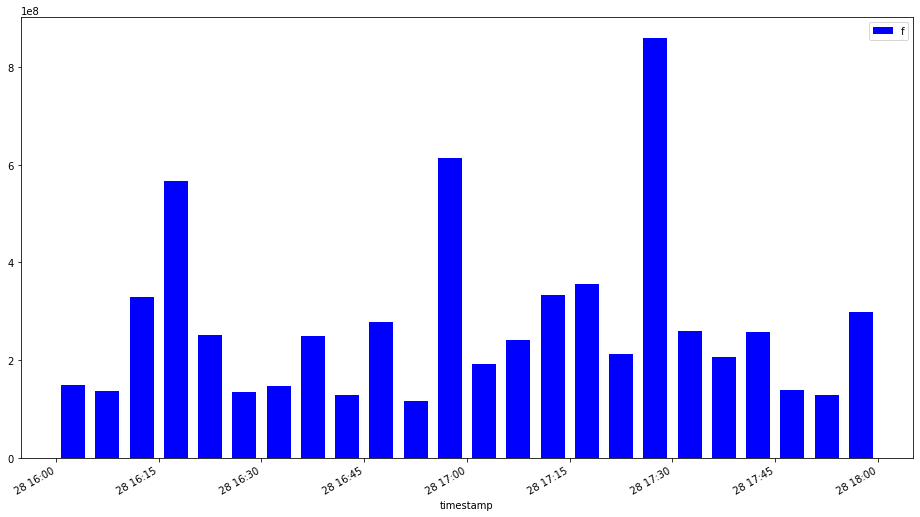

In [49]:
hist_row_function(research, total_time, bin_size=datetime.timedelta(minutes=5))

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


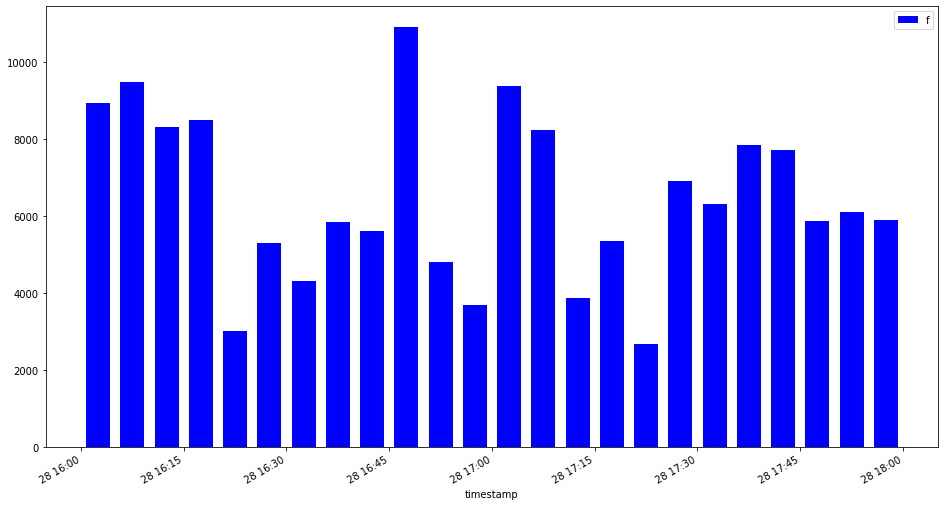

In [17]:
hist_row_function(research, lambda r: 1, bin_size=datetime.timedelta(minutes=5))

In [20]:
def hist_positive_negative_function(df, f_pos, f_neg, label_pos=None, label_neg=None, **kwargs):
    plt.figure(figsize=(16, 9))
    
    _hist_row_function(df, f_pos, label=label_pos, **kwargs)
    _hist_row_function(df, lambda r: -f_neg(r), color='r', label=label_neg, **kwargs)
    
    plt.legend()
    plt.show()

In [22]:
out_research = filter_one_vs_all('research')
out_research

,statistics,event_type,timestamp,resource_limits,preemptor_operation_id,preemptor_pool,preempted_operation_id,preempted_pool
1,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 16:00:00.004573,"{'user_slots': 1, 'network': 0, 'user_memory':...",bd376a8e-56df4c7e-3fe03e8-a3fbb800,robot-disk-stat,da237cc8-1fa919c6-3fe03e8-7c7c3927,robot-direct-yt
2,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 16:00:00.008908,"{'user_slots': 1, 'network': 0, 'user_memory':...",bd376a8e-56df4c7e-3fe03e8-a3fbb800,robot-disk-stat,bdffb21-1ca9df14-3fe03e8-d33015b7,robot-video-series
4,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 16:00:00.012027,"{'user_slots': 1, 'network': 0, 'user_memory':...",bd376a8e-56df4c7e-3fe03e8-a3fbb800,robot-disk-stat,5219361-b3cf6dab-3fe03e8-be3d8bb6,robot-zen
5,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 16:00:00.012113,"{'user_slots': 1, 'network': 0, 'user_memory':...",b7a7434e-7d83bbad-3fe03e8-d986f33d,logfeller_build_fast_logs,b4cbda86-f7dbb186-3fe03e8-be64a88b,robot-redcat
7,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 16:00:00.026394,"{'user_slots': 1, 'network': 3, 'user_memory':...",b7a7434e-7d83bbad-3fe03e8-d986f33d,logfeller_build_fast_logs,645dedbe-2cb9994d-3fe03e8-b296e9cb,research
...,...,...,...,...,...,...,...,...
2761212,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 17:59:59.991437,"{'user_slots': 1, 'network': 0, 'user_memory':...",3b6cfd13-b96bde3b-3fe03e8-ddf977a6,logfeller_index_streams,3bacc91d-29a788d-3fe03e8-28a381e6,research
2761214,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 17:59:59.992701,"{'user_slots': 1, 'network': 0, 'user_memory':...",e64bbdfa-113c5def-3fe03e8-e20f60bd,logfeller_index_streams,3fda5ddb-2c8fe367-3fe03e8-99cde728,research
2761215,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 17:59:59.992939,"{'user_slots': 1, 'network': 0, 'user_memory':...",26681d90-f84195c9-3fe03e8-2961fbe6,yabs-cs-preprod-5-base-gen,8fcdd03d-f1099ac3-3fe03e8-4100ea8b,search-research_ptyavin
2761219,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 17:59:59.994611,"{'user_slots': 1, 'network': 0, 'user_memory':...",26681d90-f84195c9-3fe03e8-2961fbe6,yabs-cs-preprod-5-base-gen,e6995dd1-9d1855cc-3fe03e8-2328086d,research


In [36]:
def hist_two_way_function(df, checker, f, **kwargs):
    pred = create_unidirectional_predicate(checker)
    def f_pos(row):
        return f(row) if pred(row) else 0
    def f_neg(row):
        return f(row) if not pred(row) else 0
    hist_positive_negative_function(df, f_pos, f_neg, **kwargs)
    
def hist_one_vs_one_preemption(parent1, parent2, f, **kwargs):
    df = filter_one_vs_one(parent1, parent2)
    checker = _create_one_vs_one_checker(parent1, parent2)
    hist_two_way_function(df, checker, f, label_pos=f'{parent1} -> {parent2}', label_neg=f'{parent2} -> {parent1}', **kwargs)
    
def hist_one_vs_all_preemption(parent, f, **kwargs):
    df = filter_one_vs_all(parent)
    checker = _create_one_vs_all_checker(parent)
    hist_two_way_function(df, checker, f, label_pos=f'{parent} -> others', label_neg=f'others -> {parent}', **kwargs)

def hist_subtree_preemption(parent, f, **kwargs):
    df = filter_subtree(parent)
    checker = _create_subtree_checker(parent)
    hist_row_function(df, f, bin_size=datetime.timedelta(minutes=5), **kwargs)

def hist_anti_subtree_preemption(parent, f, **kwargs):
    df = filter_anti_subtree(parent)
    checker = _create_anti_subtree_checker(parent)
    hist_row_function(df, f, bin_size=datetime.timedelta(minutes=5), **kwargs)

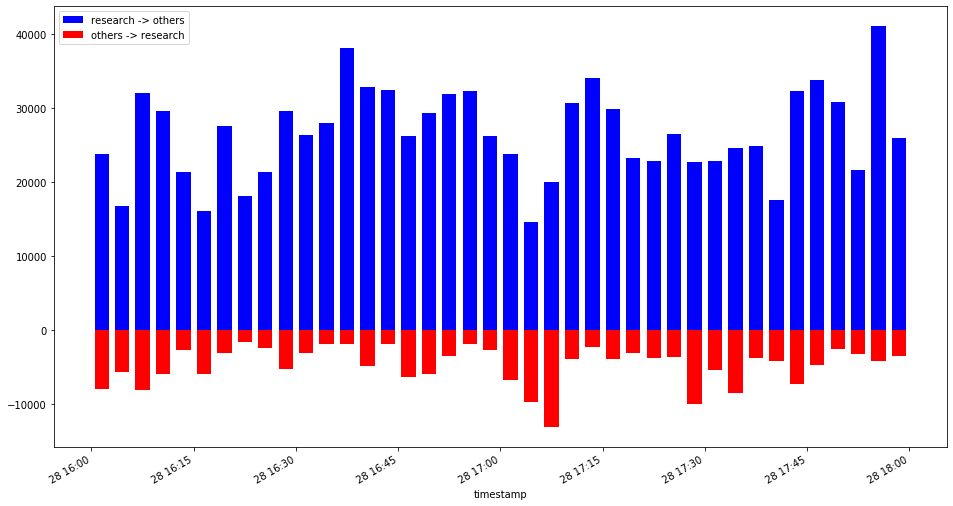

In [27]:
hist_one_vs_all_preemption('research', lambda r: 1)

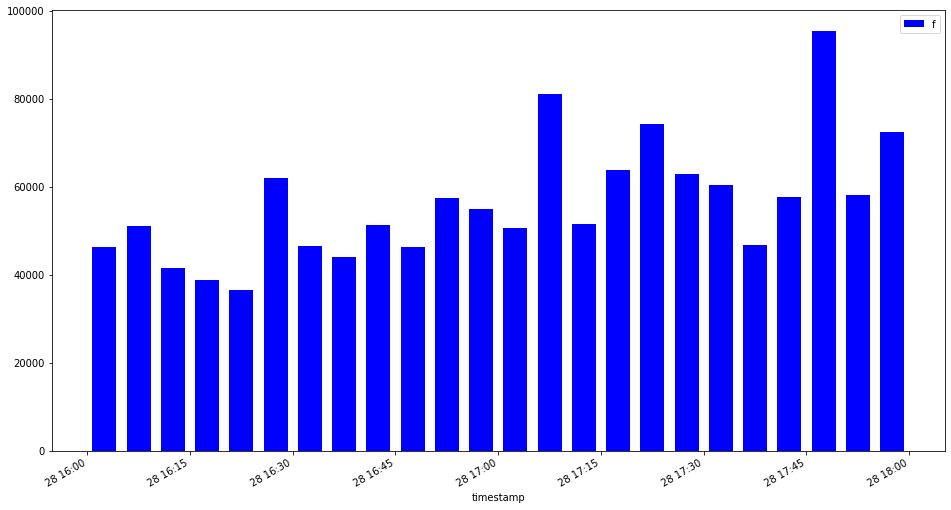

In [34]:
hist_anti_subtree_preemption('research', lambda r: 1, lable='job count')

### Preempted jobs

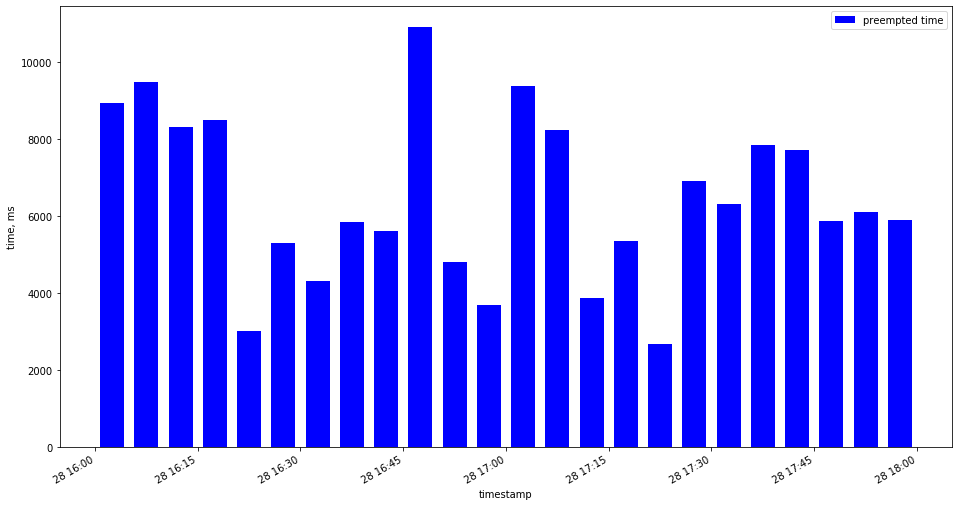

In [42]:
hist_subtree_preemption('research', lambda r: 1, label='preempted time', ylabel='time, ms')

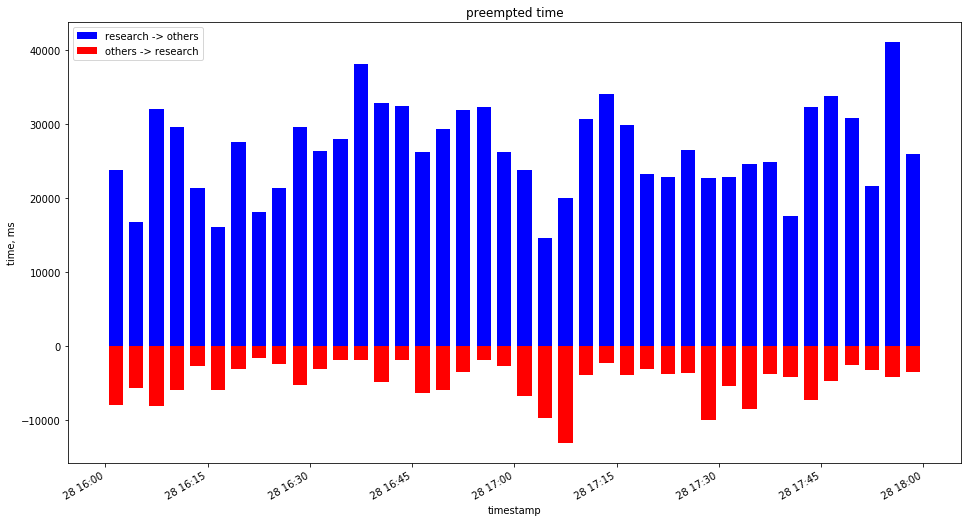

In [43]:
hist_one_vs_all_preemption('research', lambda r: 1, title='preempted time', ylabel='time, ms')

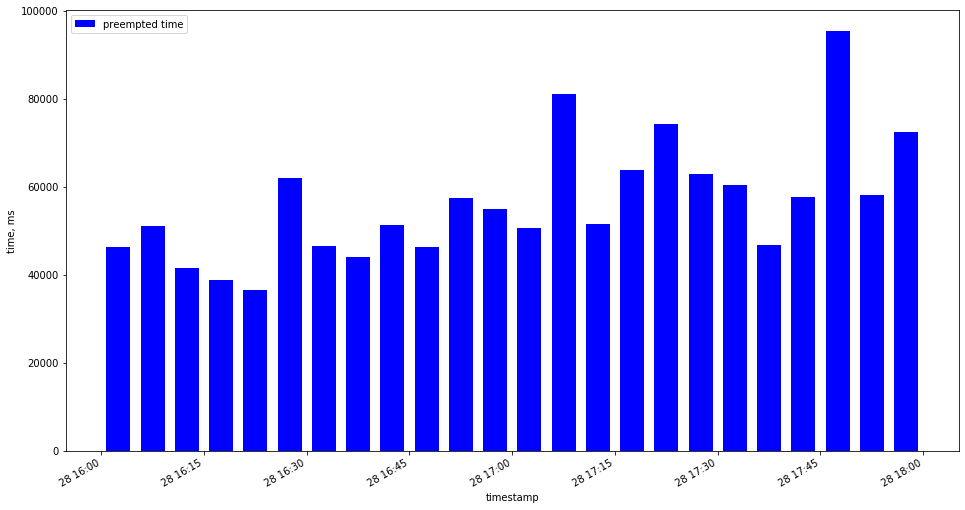

In [44]:
hist_anti_subtree_preemption('research', lambda r: 1, label='preempted time', ylabel='time, ms')

### Preempted time

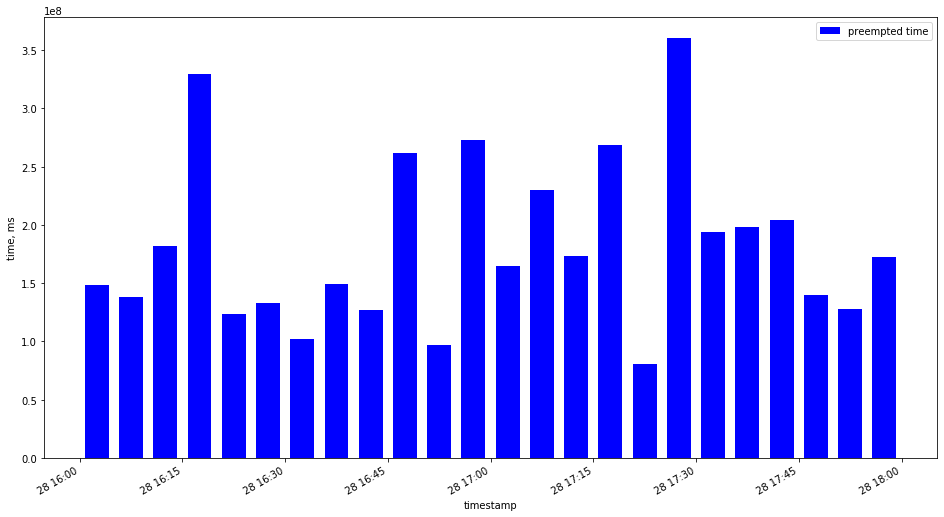

In [38]:
hist_subtree_preemption('research', total_time, label='preempted time', ylabel='time, ms')

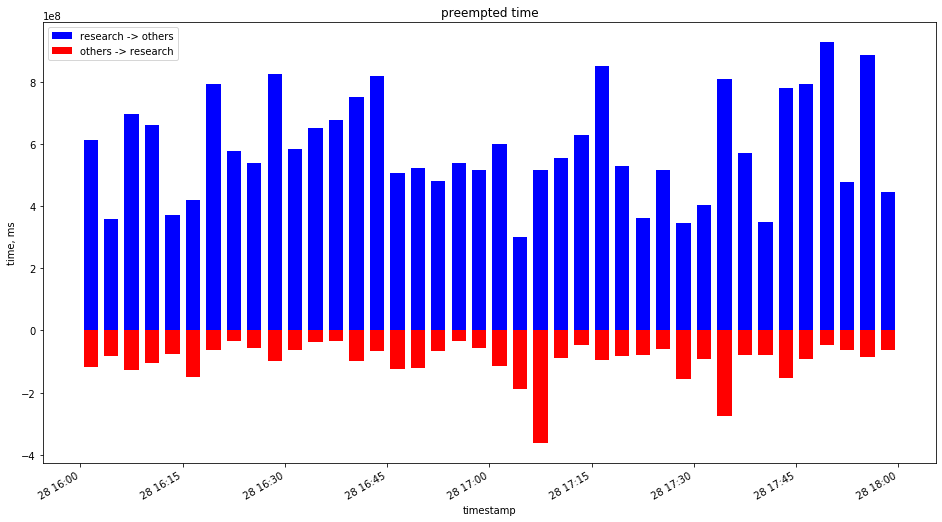

In [40]:
hist_one_vs_all_preemption('research', total_time, title='preempted time', ylabel='time, ms')

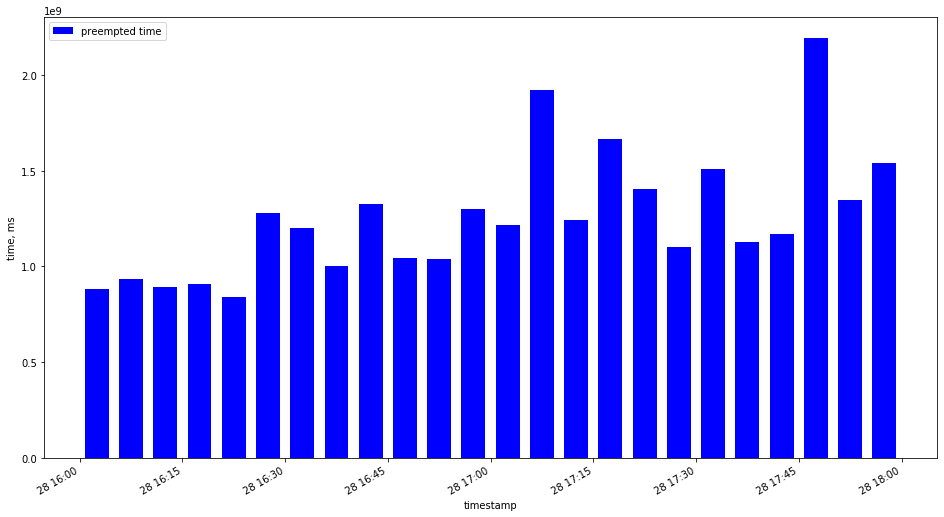

In [41]:
hist_anti_subtree_preemption('research', total_time, label='preempted time', ylabel='time, ms')

### Топ рёбер

In [169]:
from functools import partial

def _get_parent_pool(pool, level):
    path = pool_path_list_mapping[pool]
    level = min(level, len(path) - 1)
    return path[level]

def _get_level_edge(level, row):
    return (
        _get_parent_pool(row['preempted_pool'], level), 
        _get_parent_pool(row['preemptor_pool'], level)
    )

def _edge_stats(get_edge, row):
    try:
        f, t = get_edge(row)
        return pd.Series({
            'from': f,
            'to': t,
            'count': 1,
            'time': total_time(row),
        })
    except:
        print(row)
        raise

def get_edge_statistics(df, get_edge=None):
    if get_edge is None:
        get_edge = partial(_get_level_edge, 1)
    return df.apply(partial(_edge_stats, get_edge), axis=1).groupby(['from', 'to']).sum()

In [ ]:
def 

In [ ]:
deep_edge_stats = get_edge_statistics(preemptions, 3)

In [157]:
edge_stats = get_edge_statistics(preemptions)
edge_stats

count        time
from     to                                   
abt      abt                   410    10789733
         acs                   165     2367915
         antifraud-xurma        39     1201728
         audience-geo-heavy     15      214598
         b2bgeo                  2      474484
...                            ...         ...
yabs_all web-relevance-root     44      814481
         yabs-cs-preprod      8807   230835214
         yabs-cs-prod        44225  1010349349
         yabs-stat           14575   266184539
         yabs_all            17943   480153300

[3813 rows x 2 columns]

In [158]:
edge_stats['ratio'] = edge_stats['time'] / edge_stats['time'].sum()

In [159]:
edge_stats_sorted = edge_stats.sort_values(['time'], ascending=False).reset_index()

In [160]:
edge_stats_sorted.head(10)

,from,to,count,time,ratio
0,research,robot-logfeller,373237,7819949891,0.121917
1,research,research,154621,6588177501,0.102713
2,research,yabs-cs-prod,139114,3216451006,0.050146
3,yabs_all,robot-logfeller,122449,2633592791,0.041059
4,research,statbox_all,87993,1630786393,0.025425
5,research,yabs_all,60091,1425630642,0.022226
6,research,market-root,55863,1425000901,0.022216
7,yabs_all,yabs-cs-prod,44225,1010349349,0.015752
8,research,nirvana,7948,996901260,0.015542
9,yabs_all,research,45804,960604132,0.014976


calculated


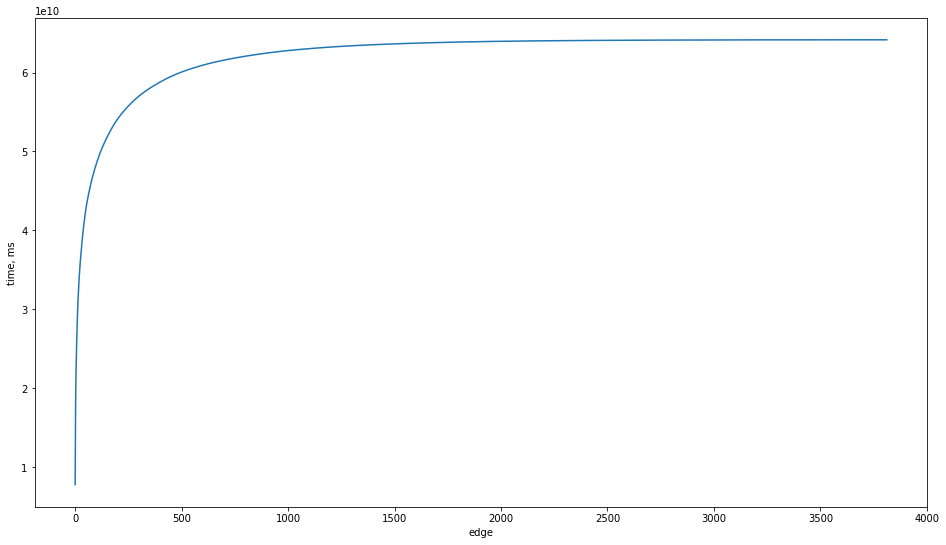

In [128]:
edge_names = edge_stats_sorted[['from', 'to']].apply(lambda r: r['from'] + '->' + r['to'], axis=1)

plt.figure(figsize=(16, 9))
plt.plot(edge_stats_sorted['time'].cumsum(), label='total_time')

plt.xlabel('edge')
plt.ylabel('time, ms')
plt.show()

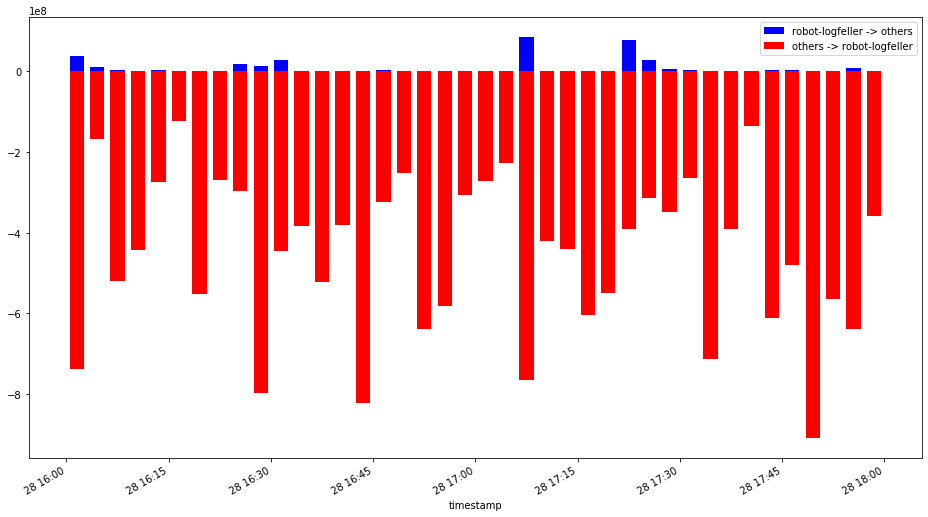

In [130]:
hist_one_vs_all_preemption("robot-logfeller", total_time)

In [147]:
edge_stats_preemptor = edge_stats.groupby("to").sum().sort_values(["time"], ascending=False)
edge_stats_preemptor

,count,time,ratio
to,,,
robot-logfeller,866357,18313662208,2.855186e-01
research,342996,10497302911,1.636579e-01
yabs-cs-prod,314723,7263842089,1.132467e-01
statbox_all,201612,3808843877,5.938167e-02
yabs_all,134325,3290148699,5.129497e-02
...,...,...,...
transfer_jupiter,4,163684,2.551911e-06
maps_analytics,4,124735,1.944678e-06
toloka-analytics,1,109865,1.712847e-06


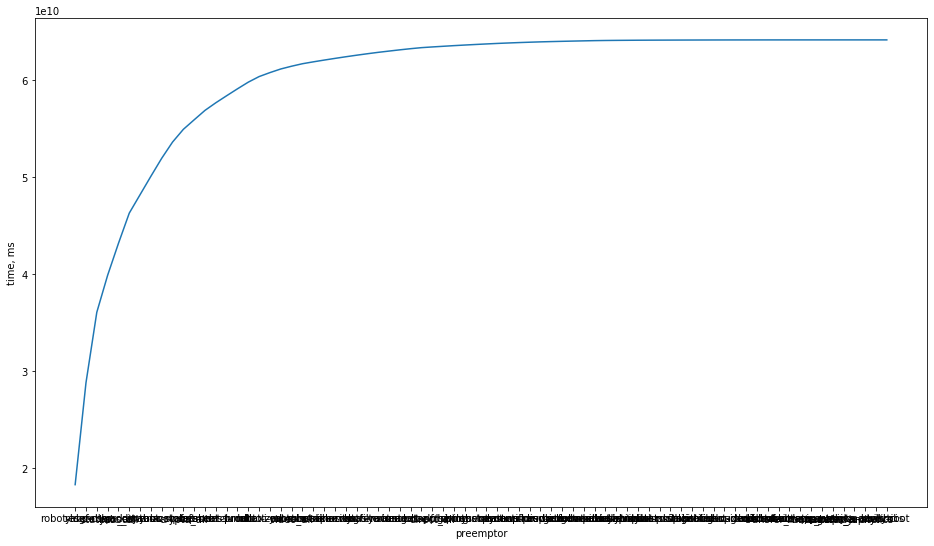

In [153]:
plt.figure(figsize=(16, 9))
plt.plot(edge_stats_preemptor['time'].cumsum(), label='total_time')

plt.xlabel('preemptor')
plt.ylabel('time, ms')
plt.show()

In [143]:
preemptor_distr_function = edge_stats_preemptor['time'].cumsum() / edge_stats_preemptor['time'].sum()
preemptor_distr_function['robot-logfeller']

0.2855186349543228

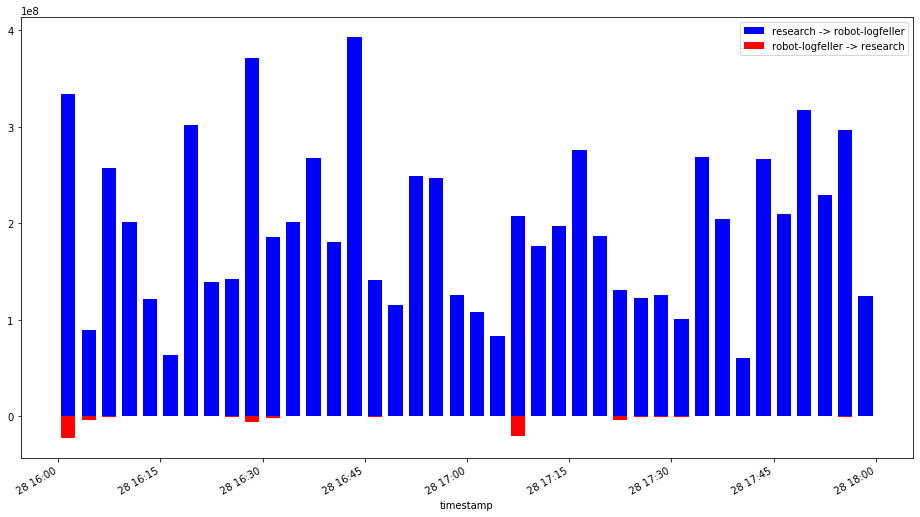

In [144]:
hist_one_vs_one_preemption('research', 'robot-logfeller', total_time)

In [152]:
edge_stats_preemptor['ratio']['research']

0.16365790543747688

### Logfeller

In [166]:
len(deep_edge_stats)

40547

In [184]:
deep_edge_stats

count     time
from              to                                   
24julia           abt-prod-ems               3    55120
                  abt-prod-period           89  1902061
                  adfox-stat                 1     6091
                  adv-machine                1     6950
                  altay-db                   3   102509
...                                        ...      ...
yabs_merge_chunks yabs-cs-prod-2-direct     20   282600
                  yabs-cs-prod-2-export      4   420838
                  yabs-cs-prod-2-import      5    62883
                  yabs-log                   5   319601
                  yabs-stat-yql              1     4267

[40547 rows x 2 columns]

In [185]:
deep_edge_stats['ratio'] = deep_edge_stats['time'] / deep_edge_stats['time'].sum()

In [186]:
def _patch_row(row):
    def get_pool(pool):
        if _get_parent_pool(pool, 1) == 'robot-logfeller':
            return _get_parent_pool(pool, 2)
        return _get_parent_pool(pool, 1)
    
    row['from'] = get_pool(row['from'])
    row['to'] = get_pool(row['to'])
    return row

def emphasize_logfeller(stats):
    stats_reset = stats.reset_index()
    stats_grouped = stats_reset.apply(_patch_row, axis=1).groupby(['from', 'to']).sum()
    return stats_grouped

In [187]:
stats_logfeller = emphasize_logfeller(deep_edge_stats)

In [188]:
stats_logfeller = stats_logfeller.sort_values(['time'], ascending=False)
stats_logfeller

count        time         ratio
from               to                                                       
research           research                 154621  6588177501  1.027128e-01
                   logfeller_index_streams  207522  4633626881  7.224043e-02
                   yabs-cs-prod             139114  3216451006  5.014599e-02
                   logfeller_ultrafast       84940  1683459854  2.624593e-02
                   statbox_all               87993  1630786393  2.542473e-02
...                                            ...         ...           ...
audience-geo-heavy meteo                         1        2577  4.017665e-08
mlmarines          constructor-platform          1        2428  3.785367e-08
shinyserp          meteo                         1        2285  3.562423e-08
crypta_all         robot-scraperoveryt           1        2070  3.227228e-08
cron               robot-scraperoveryt           1        1871  2.916977e-08

[4327 rows x 3 columns]

In [189]:
stats_logfeller_only = stats_logfeller.reset_index()[
    stats_logfeller.reset_index().apply(lambda r: _get_parent_pool(r['to'], 1) == 'robot-logfeller', axis=1)
]

In [190]:
stats_logfeller_only

,from,to,count,time,ratio
1,research,logfeller_index_streams,207522,4633626881,7.224043e-02
3,research,logfeller_ultrafast,84940,1683459854,2.624593e-02
5,yabs_all,logfeller_index_streams,68997,1584560661,2.470405e-02
8,research,logfeller_build_fast_logs,58988,1073861546,1.674201e-02
17,yabs_all,logfeller_ultrafast,25850,529634940,8.257259e-03
...,...,...,...,...,...
4259,taxi-dwh-dev,logfeller_archive_logs,1,5778,9.008175e-08
4268,metrika-root,logfeller_ultrafast_guarantee,1,5593,8.719751e-08
4272,robot-fact-snip,logfeller_build_logs,1,5535,8.629326e-08
4276,abt,logfeller_ultrafast_guarantee,1,5450,8.496807e-08


In [191]:
stats_logfeller_sorted = stats_logfeller_only.groupby(['to']).sum().sort_values(['time'], ascending=False)
stats_logfeller_sorted

,count,time,ratio
to,,,
logfeller_index_streams,477500,10778719210,0.168045
logfeller_ultrafast,189462,3815586999,0.059487
logfeller_build_fast_logs,143127,2602565171,0.040575
logfeller_build_guarantee_logs,37700,713388636,0.011122
logfeller_archive_logs,15568,353278981,0.005508
logfeller_build_logs,2971,49616613,0.000774
logfeller_ultrafast_guarantee,29,506598,0.000008


In [192]:
stats_logfeller_only[stats_logfeller_only['to'] == 'logfeller_index_streams']

,from,to,count,time,ratio
1,research,logfeller_index_streams,207522,4633626881,7.224043e-02
5,yabs_all,logfeller_index_streams,68997,1584560661,2.470405e-02
18,crypta_all,logfeller_index_streams,23240,508433840,7.926723e-03
25,safesearch,logfeller_index_streams,14572,323612910,5.045278e-03
31,robot-zen,logfeller_index_streams,9870,285543864,4.451764e-03
...,...,...,...,...,...
2782,pythia,logfeller_index_streams,15,174912,2.726961e-06
2993,maps_analytics,logfeller_index_streams,5,123063,1.918610e-06
3161,garden,logfeller_index_streams,6,93168,1.452533e-06
3638,cloud_analytics_pool,logfeller_index_streams,2,37704,5.878232e-07


In [195]:
logfeller_index_events = preemptions[preemptions['preemptor_pool'] == 'logfeller_index_streams']
logfeller_index_events

,statistics,event_type,timestamp,resource_limits,preemptor_operation_id,preemptor_pool,preempted_operation_id,preempted_pool
66,"{'user_job': {'memory_limit': {'count': 1, 'ma...",job_aborted,2019-11-28 16:00:00.144246,"{'user_slots': 1, 'network': 0, 'user_memory':...",c3c14612-7b2bd7a6-3fe03e8-38bf4b36,logfeller_index_streams,c2befbc5-a40176b0-3fe03e8-16d76cff,broadmatching
70,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 16:00:00.145388,"{'user_slots': 1, 'network': 0, 'user_memory':...",4ce23f0b-9120247-3fe03e8-50321a2,logfeller_index_streams,bdffb21-1ca9df14-3fe03e8-d33015b7,robot-video-series
77,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 16:00:00.165928,"{'user_slots': 1, 'network': 0, 'user_memory':...",4ce23f0b-9120247-3fe03e8-50321a2,logfeller_index_streams,48d36739-c9685d1b-3fe03e8-59ffe55f,factor_check
100,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 16:00:00.242133,"{'user_slots': 1, 'network': 0, 'user_memory':...",c3c14612-7b2bd7a6-3fe03e8-38bf4b36,logfeller_index_streams,f3e5acef-b7ec8bf5-3fe03e8-53c343c9,robot-ynews
103,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 16:00:00.243247,"{'user_slots': 1, 'network': 0, 'user_memory':...",c3c14612-7b2bd7a6-3fe03e8-38bf4b36,logfeller_index_streams,412b062-462bf436-3fe03e8-fd126900,research
...,...,...,...,...,...,...,...,...
2761206,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 17:59:59.982120,"{'user_slots': 1, 'network': 0, 'user_memory':...",3b6cfd13-b96bde3b-3fe03e8-ddf977a6,logfeller_index_streams,58e1704e-adb4767d-3fe03e8-55d2485,research
2761210,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 17:59:59.986604,"{'user_slots': 1, 'network': 0, 'user_memory':...",3b6cfd13-b96bde3b-3fe03e8-ddf977a6,logfeller_index_streams,e2350250-cbb9b6b4-3fe03e8-fe0dfde6,research
2761212,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 17:59:59.991437,"{'user_slots': 1, 'network': 0, 'user_memory':...",3b6cfd13-b96bde3b-3fe03e8-ddf977a6,logfeller_index_streams,3bacc91d-29a788d-3fe03e8-28a381e6,research
2761213,{'job_proxy': {'memory_reserve_factor_x10000':...,job_aborted,2019-11-28 17:59:59.992292,"{'user_slots': 1, 'network': 0, 'user_memory':...",1c57f005-708256dc-3fe03e8-70f36184,logfeller_index_streams,d442585f-f1f55366-3fe03e8-eabacfe3,adv-machine


In [200]:
logfeller_index_events.groupby(['preemptor_operation_id']).count().reset_index().sort_values(['statistics'])

,preemptor_operation_id,statistics,event_type,timestamp,resource_limits,preemptor_pool,preempted_operation_id,preempted_pool
1349,62ff4ad2-bf1df765-3fe03e8-600ab8c0,1,1,1,1,1,1,1
2537,af4cf827-fa7b649-3fe03e8-2c592818,1,1,1,1,1,1,1
1438,68759148-657fe7db-3fe03e8-4d6de05e,1,1,1,1,1,1,1
3268,df49b4b3-11b235e0-3fe03e8-67f18a3e,1,1,1,1,1,1,1
3270,df61a2bb-6b607cf7-3fe03e8-b3b155de,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
2566,b0ce924c-9cf4a4ba-3fe03e8-bbeb3cee,6587,6587,6587,6587,6587,6587,6587
3102,d3a6d2af-8c85e84b-3fe03e8-124679c8,7034,7034,7034,7034,7034,7034,7034
3756,fdaa11c5-47f5e102-3fe03e8-67a6cb45,7739,7739,7739,7739,7739,7739,7739
1398,663315a2-d793708e-3fe03e8-b6d311c6,25423,25423,25423,25423,25423,25423,25423


In [209]:
pool_name_mapping['robot-logfeller'].attributes['min_share_resources']['cpu']

23936

In [227]:
def _enrich_with_resources(row):
    attributes = pool_name_mapping[row['to']].attributes
    try:
        row['cpu_guarantee'] = attributes['min_share_resources']['cpu']
    except KeyError:
        row['cpu_guarantee'] = 0
        
    try:
        row['weight'] = attributes['weight']
    except KeyError:
        row['weight'] = 0
    
    return row

In [229]:
enriched_preemptor_stats = edge_stats_preemptor.reset_index().apply(_enrich_with_resources, axis=1)
enriched_logfeller_stats = stats_logfeller_sorted.reset_index().apply(_enrich_with_resources, axis=1)

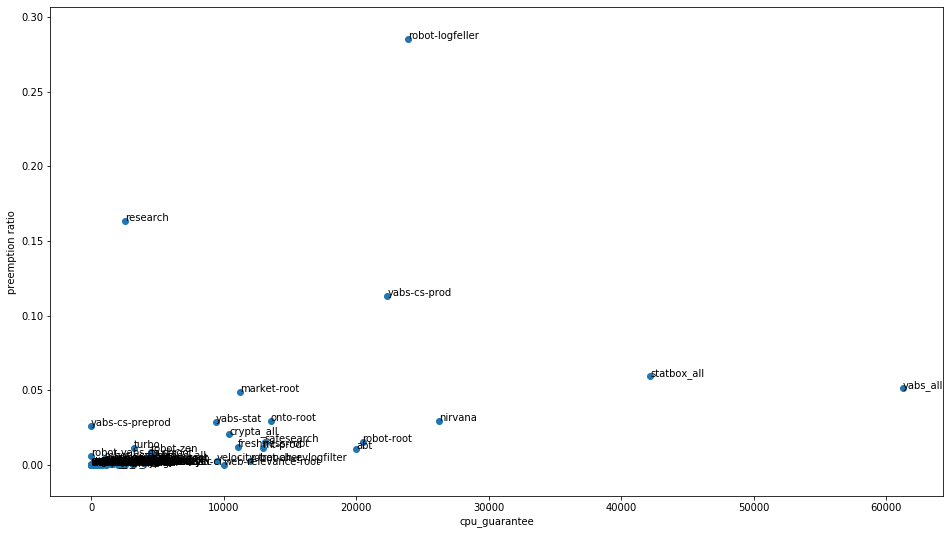

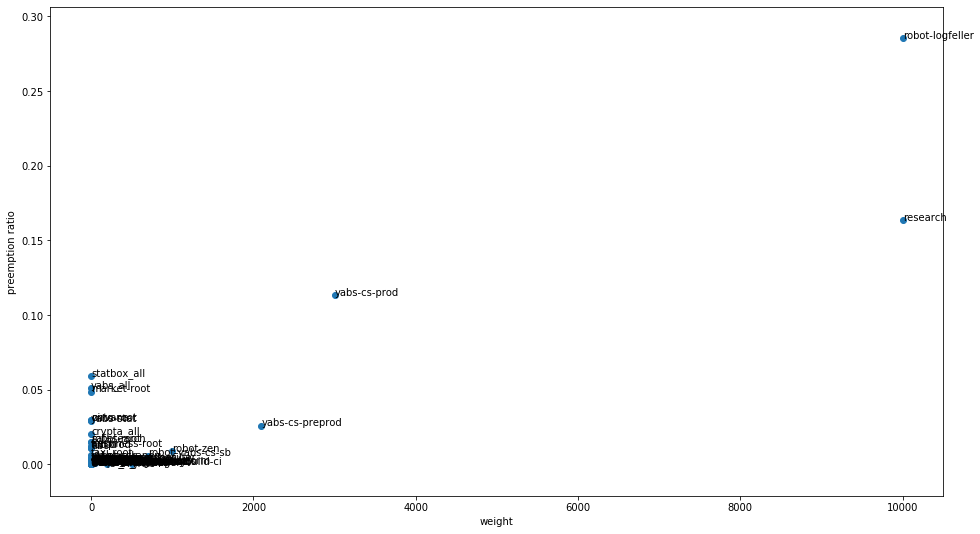

In [236]:
for feature in ['cpu_guarantee', 'weight']:
    plt.figure(figsize=(16, 9))
    x = enriched_preemptor_stats[feature]
    y = enriched_preemptor_stats['ratio']
    labels = enriched_preemptor_stats['to']
    plt.scatter(x, y)
    for i in range(len(enriched_preemptor_stats)):
        plt.annotate(labels[i], (x[i], y[i]))
    
    plt.xlabel(feature)
    plt.ylabel('preemption ratio')
    plt.show()

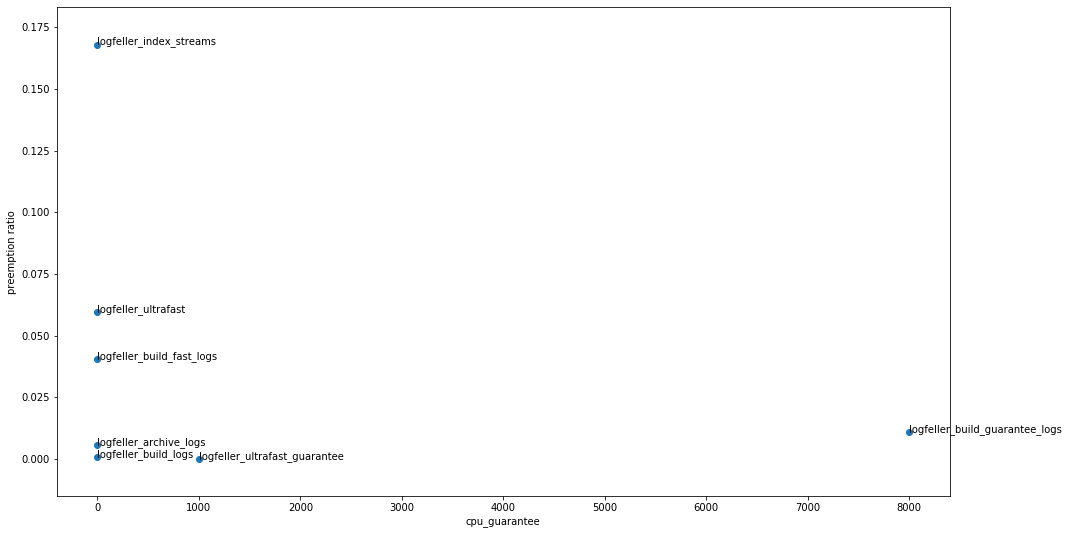

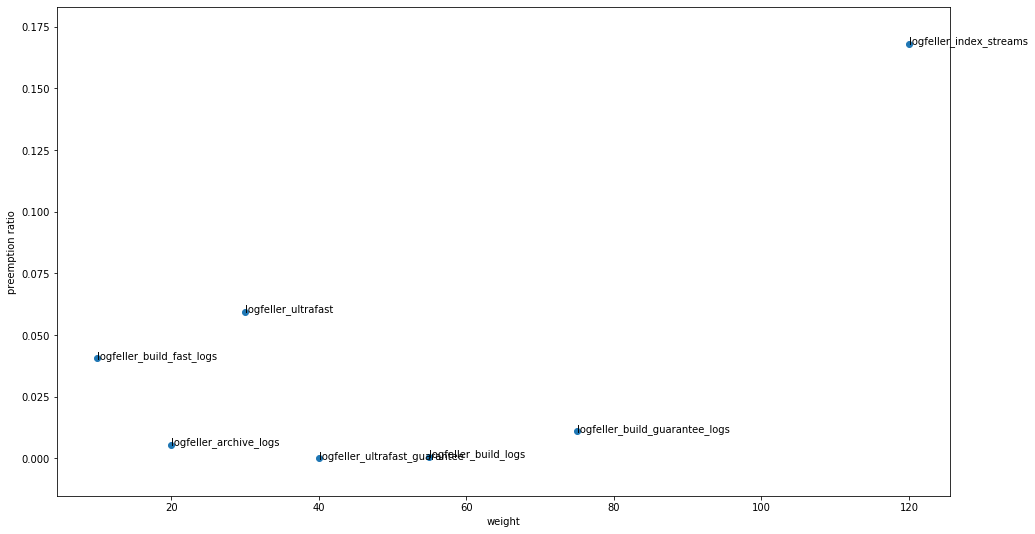

In [239]:
for feature in ['cpu_guarantee', 'weight']:
    plt.figure(figsize=(16, 9))
    x = enriched_logfeller_stats[feature]
    y = enriched_logfeller_stats['ratio']
    labels = enriched_logfeller_stats['to']
    plt.scatter(x, y)
    for i in range(len(enriched_logfeller_stats)):
        plt.annotate(labels[i], (x[i], y[i]))
    
    plt.xlabel(feature)
    plt.ylabel('preemption ratio')
    plt.show()